In [ ]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano

from scipy import stats
from sklearn.metrics import mean_squared_error
import math

import matplotlib.pyplot as plt
import arviz as az

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
pd.set_option("precision", 2)

### Exercise 1

Consider three fictional Polynesian islands. On each there is a Royal Ornithologist charged by the king with surveying the birb population. They have each found the following proportions of 5 important birb species:

In [ ]:
data = [['Island 1', 0.2, 0.2, 0.2, 0.2, 0.2], ['Island 2', 0.8, 0.1, 0.05, 0.025, 0.025], ['Island 3', 0.05, 0.15, 0.7, 0.05, 0.05]] 
df = pd.DataFrame(data, columns = ['Island', 'Bird A', 'Bird B', 'Bird C', 'Bird D', 'Bird E'])
df.set_index("Island", inplace=True)
df

,Bird A,Bird B,Bird C,Bird D,Bird E
Island,,,,,
Island 1,0.20,0.20,0.20,0.20,0.20
Island 2,0.80,0.10,0.05,0.03,0.03
Island 3,0.05,0.15,0.70,0.05,0.05


In [ ]:
df.columns

Index(['Bird A', 'Bird B', 'Bird C', 'Bird D', 'Bird E'], dtype='object')

In [ ]:
cols = ['Bird A', 'Bird B', 'Bird C', 'Bird D', 'Bird E']
df["entropy"] = df["Bird A"] * np.log(df["Bird A"]) + \
                df["Bird B"] * np.log(df["Bird B"]) + \
                df["Bird C"] * np.log(df["Bird C"]) + \
                df["Bird D"] * np.log(df["Bird D"]) + \
                df["Bird E"] * np.log(df["Bird E"])

In [ ]:
df["entropy"] = df["entropy"] * -1
df

,Bird A,Bird B,Bird C,Bird D,Bird E,entropy
Island,,,,,,
Island 1,0.20,0.20,0.20,0.20,0.20,1.61
Island 2,0.80,0.10,0.05,0.03,0.03,0.74
Island 3,0.05,0.15,0.70,0.05,0.05,0.98


In [ ]:
x = np.linspace(0, 1, 1000)
y = - x * np.log(x)

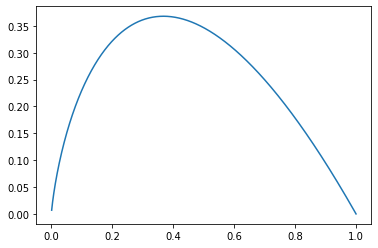

In [ ]:
plt.plot(x,y)

In [ ]:
cols = ['Bird A', 'Bird B', 'Bird C', 'Bird D', 'Bird E']
def kl_distance(p, q):
    distance = (df.loc[p, cols] * 
                (np.log(df.loc[p, cols]) - 
                 np.log(df.loc[q, cols])))
    return distance.sum().round(2)

In [ ]:
kl_distance("Island 1", "Island 2"), kl_distance("Island 3", "Island 2")\

(0.97, 1.84)

In [ ]:
kl_distance("Island 2", "Island 1"), kl_distance("Island 3", "Island 1")

(0.87, 0.63)

In [ ]:
kl_distance("Island 1", "Island 3"), kl_distance("Island 2", "Island 3")0.63)

(0.64, 2.01)